# Autoencoder for Binary Occupancy Detection

**Goal**: Detect empty room (NA) vs occupied (any other activity) using a two-stage autoencoder.

**Approach**:
- Stage 1: Train autoencoder on NA (empty room) data only
- Stage 2: Freeze encoder, add classification head, train binary classifier

**Architecture**: 10,400 → 512 → 256 → 64 → 256 → 512 → 10,400

## 1. Setup & Imports

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


## 2. Data Loading & Segmentation

Load raw CSI data and create 200-packet segments with sliding window.

In [29]:
def parse_csi_data(csi_string):
    """
    Parse CSI_DATA string into numpy array.
    Format: [128 values] = 64 subcarriers (real, imag pairs)
    Returns: Array of 64 amplitude values
    """
    # Remove brackets and split
    values = csi_string.strip('[]').split()
    values = [int(v) for v in values]
    
    # Should have exactly 128 values (64 subcarriers × 2)
    if len(values) != 128:
        print(f"WARNING: CSI_DATA has {len(values)} values, expected 128. Skipping.")
        return None
    
    # Compute amplitude for each subcarrier
    amplitudes = []
    for i in range(0, 128, 2):
        real = values[i]
        imag = values[i+1]
        amplitude = np.sqrt(real**2 + imag**2)
        amplitudes.append(amplitude)
    
    return np.array(amplitudes)

def load_and_segment_csv(file_path, activity, window_size=200, stride=200):
    """
    Load CSV file and create segments.
    
    Args:
        file_path: Path to CSV file
        activity: Activity label (JJ, LA, LL, NA, RA, RL, SO)
        window_size: Number of packets per segment (default: 200)
        stride: Step size for sliding window (default: 200, no overlap)
    
    Returns:
        segments: List of (200, 64) arrays
        labels: List of activity labels
    """
    df = pd.read_csv(file_path)
    
    # Parse CSI_DATA column
    csi_amplitudes = []
    skipped = 0
    for csi_string in df['CSI_DATA']:
        amp = parse_csi_data(csi_string)
        if amp is not None:
            csi_amplitudes.append(amp)
        else:
            skipped += 1
    
    if skipped > 0:
        print(f"  Skipped {skipped} malformed packets in {file_path}")
    
    csi_array = np.array(csi_amplitudes)  # Shape: (num_packets, 64)
    
    # Create segments with sliding window
    segments = []
    labels = []
    
    for start in range(0, len(csi_array) - window_size + 1, stride):
        segment = csi_array[start:start + window_size]  # Shape: (200, 64)
        segments.append(segment)
        labels.append(activity)
    
    return segments, labels

# Load all data
raw_data_path = '../datasets/01-tvat-raw'
all_segments = []
all_labels = []

activities = ['JJ', 'LA', 'LL', 'NA', 'RA', 'RL', 'SO']

for activity in activities:
    print(f"Loading {activity} data...")
    activity_segments = 0
    
    for i in range(1, 7):  # 6 files per activity
        file_path = os.path.join(raw_data_path, f'tvat-{activity}-{i}.csv')
        if os.path.exists(file_path):
            segments, labels = load_and_segment_csv(file_path, activity)
            all_segments.extend(segments)
            all_labels.extend(labels)
            activity_segments += len(segments)
    
    print(f"  {activity}: {activity_segments} segments")

print(f"\nTotal segments: {len(all_segments)}")
print(f"Segment shape: {all_segments[0].shape}")

Loading JJ data...
  JJ: 214 segments
Loading LA data...
  LA: 173 segments
Loading LL data...
  LL: 204 segments
Loading NA data...
  NA: 209 segments
Loading RA data...
  RA: 213 segments
Loading RL data...
  RL: 166 segments
Loading SO data...
  SO: 199 segments

Total segments: 1378
Segment shape: (200, 64)


## 3. Data Preprocessing

Drop guard bands, flatten, and normalize.

In [30]:
# Drop guard band subcarriers
guard_bands = [2, 3, 4, 5, 32, 59, 60, 61, 62, 63]
usable_subcarriers = [i for i in range(64) if i not in guard_bands]

print(f"Usable subcarriers: {len(usable_subcarriers)} (dropped {len(guard_bands)} guard bands)")

# Process segments: drop guard bands and flatten
processed_segments = []
for segment in all_segments:
    # Keep only usable subcarriers: (200, 64) → (200, 52)
    segment_clean = segment[:, usable_subcarriers]
    
    # Flatten: (200, 52) → (10400,)
    segment_flat = segment_clean.flatten()
    processed_segments.append(segment_flat)

X = np.array(processed_segments)
y = np.array(all_labels)

print(f"\nProcessed data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Features per segment: {X.shape[1]} (200 packets × 52 subcarriers)")

# Normalize with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nData normalized to range [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")

Usable subcarriers: 54 (dropped 10 guard bands)

Processed data shape: (1378, 10800)
Labels shape: (1378,)
Features per segment: 10800 (200 packets × 52 subcarriers)

Data normalized to range [0.000, 1.000]


## 4. Data Splitting

- **Train**: 80% of NA data (for autoencoder training)
- **Validation**: 20% of NA data
- **Test**: All non-NA activities + NA validation set

In [31]:
# OPTION A: Train autoencoder on ALL activities, use reconstruction error for classification

# Split all data: 80% train, 20% test (stratified by activity)
from sklearn.model_selection import train_test_split

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {len(X_train_all)} samples")
print(f"Test set: {len(X_test_all)} samples")

# Show distribution
from collections import Counter
print(f"\nTrain distribution: {dict(Counter(y_train_all))}")
print(f"Test distribution: {dict(Counter(y_test_all))}")

# Create binary labels for test set (0=NA, 1=non-NA)
y_test_binary = np.array([0 if label == 'NA' else 1 for label in y_test_all])

Training set: 1102 samples
Test set: 276 samples

Train distribution: {np.str_('RL'): 133, np.str_('JJ'): 171, np.str_('RA'): 170, np.str_('NA'): 167, np.str_('LL'): 163, np.str_('SO'): 159, np.str_('LA'): 139}
Test distribution: {np.str_('NA'): 42, np.str_('SO'): 40, np.str_('JJ'): 43, np.str_('RL'): 33, np.str_('RA'): 43, np.str_('LL'): 41, np.str_('LA'): 34}


## 5. Stage 1: Build Autoencoder

Architecture: 10,400 → 512 → 256 → **64** → 256 → 512 → 10,400

- Regularization: L2 (1e-5), Dropout (0.2), BatchNorm
- Loss: MSE reconstruction loss

In [32]:
# Separate NA and non-NA data
na_mask = (y == 'NA')
X_na = X_scaled[na_mask]
y_na = y[na_mask]

X_non_na = X_scaled[~na_mask]
y_non_na = y[~na_mask]

print(f"NA samples: {len(X_na)}")
print(f"Non-NA samples: {len(X_non_na)}")

# Split NA data: 80% train, 20% validation
X_train_na, X_val_na = train_test_split(X_na, test_size=0.2, random_state=42)

print(f"\nStage 1 (Autoencoder):")
print(f"  Train (NA only): {len(X_train_na)} samples")
print(f"  Validation (NA only): {len(X_val_na)} samples")

# For Stage 2 classification, we need balanced data
# Sample equal number of non-NA samples as NA training samples
np.random.seed(42)
non_na_indices = np.random.choice(len(X_non_na), size=len(X_train_na), replace=False)
X_train_non_na = X_non_na[non_na_indices]

# Stage 2 training data: NA (label=0) + non-NA (label=1)
X_train_stage2 = np.vstack([X_train_na, X_train_non_na])
y_train_stage2 = np.hstack([np.zeros(len(X_train_na)), np.ones(len(X_train_non_na))])

# Shuffle
shuffle_idx = np.random.permutation(len(X_train_stage2))
X_train_stage2 = X_train_stage2[shuffle_idx]
y_train_stage2 = y_train_stage2[shuffle_idx]

print(f"\nStage 2 (Classification):")
print(f"  Train: {len(X_train_stage2)} samples (balanced: {(y_train_stage2==0).sum()} NA, {(y_train_stage2==1).sum()} non-NA)")

# Test set: All non-NA + NA validation
X_test = np.vstack([X_val_na, X_non_na])
y_test = np.hstack([np.zeros(len(X_val_na)), np.ones(len(X_non_na))])

print(f"  Test: {len(X_test)} samples ({(y_test==0).sum()} NA, {(y_test==1).sum()} non-NA)")

NA samples: 209
Non-NA samples: 1169

Stage 1 (Autoencoder):
  Train (NA only): 167 samples
  Validation (NA only): 42 samples

Stage 2 (Classification):
  Train: 334 samples (balanced: 167 NA, 167 non-NA)
  Test: 1211 samples (42 NA, 1169 non-NA)


In [33]:
from tensorflow.keras import layers, regularizers

input_dim = X_train_all.shape[1]  # 10,800
l2_reg = 1e-5
dropout_rate = 0.2

# Simpler autoencoder for Option A
# Architecture: 10,800 → 256 → 64 → 256 → 10,800

encoder_input = keras.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)

# Bottleneck
bottleneck = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), name='bottleneck')(x)

# Decoder
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(bottleneck)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)

# Output (linear activation for reconstruction)
decoder_output = layers.Dense(input_dim, activation='linear')(x)

# Create autoencoder model
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     2,765,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10800)          │     2,775,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,575,792 (21.27 MB)

 Trainable params: 5,574,768 (21.27 MB)

 Non-trainable params: 1,024 (4.00 KB)

## 6. Stage 1: Train Autoencoder

Train on NA (empty room) data only to learn baseline representation.

In [34]:
# Train autoencoder on ALL activities
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience for larger dataset
    restore_best_weights=True,
    verbose=1
)

# Train autoencoder on all activities
history_ae = autoencoder.fit(
    X_train_all, X_train_all,  # Input = Output for autoencoder
    validation_split=0.2,  # 20% of training data for validation
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save autoencoder
autoencoder.save('models/autoencoder_all_activities.keras')
print("\nAutoencoder saved to models/autoencoder_all_activities.keras")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0739 - mae: 0.2076 - val_loss: 0.1906 - val_mae: 0.3369
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0425 - mae: 0.1462 - val_loss: 0.1337 - val_mae: 0.2795
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0232 - mae: 0.0884 - val_loss: 0.0699 - val_mae: 0.1983
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0194 - mae: 0.0775 - val_loss: 0.0337 - val_mae: 0.1275
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0179 - mae: 0.0723 - val_loss: 0.0223 - val_mae: 0.0954
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0168 - mae: 0.0694 - val_loss: 0.0211 - val_mae: 0.0933
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0156 - mae: 0.0650 - val_loss: 0.0157 - val_mae: 0.0673
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151 - mae: 0.0643 - val_loss: 0.0142 - val_mae: 0.0593
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

## 7. Stage 1: Visualize Training

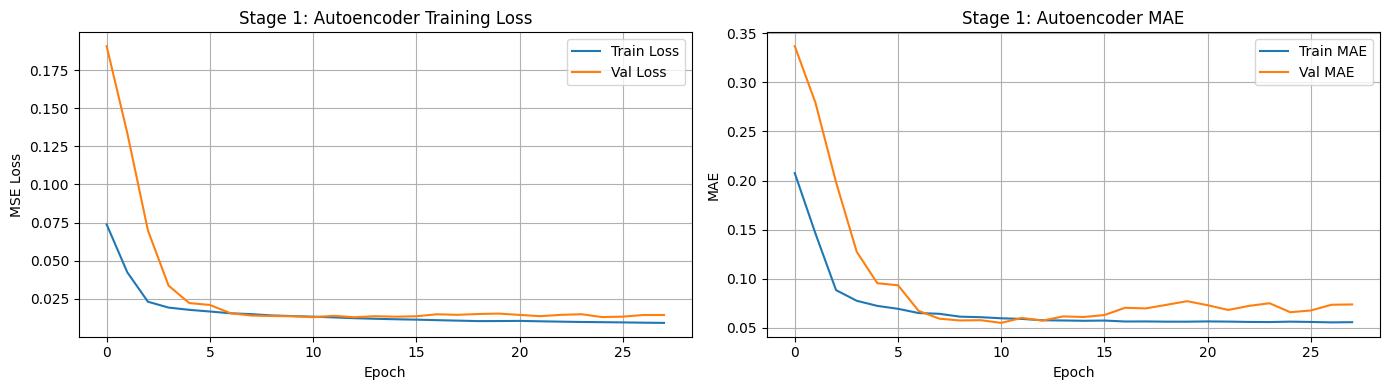

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history_ae.history['loss'], label='Train Loss')
axes[0].plot(history_ae.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Stage 1: Autoencoder Training Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history_ae.history['mae'], label='Train MAE')
axes[1].plot(history_ae.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Stage 1: Autoencoder MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 8. Stage 2: Build Classification Model

Freeze encoder, add classification head for binary classification (NA vs non-NA).

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Reconstruction Error Statistics:
NA (Empty):       Mean=0.009315, Std=0.003302
Occupied:         Mean=0.009354, Std=0.003413
Difference:       0.000039


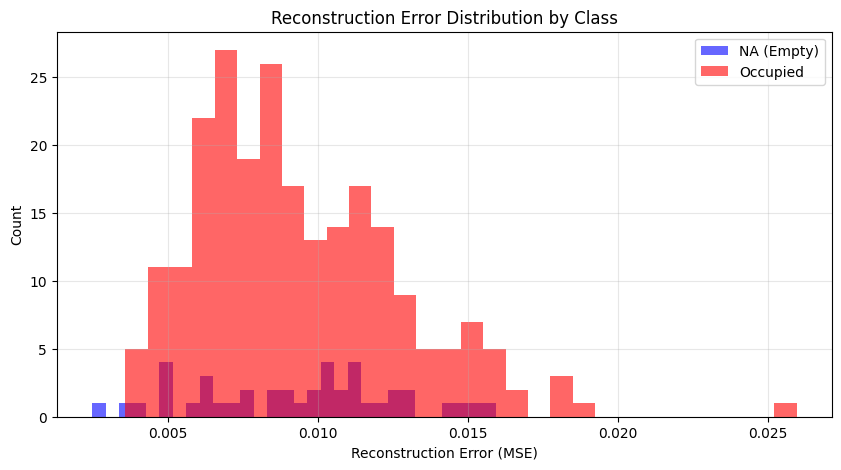

In [36]:
# Option A: Use reconstruction error for binary classification

# Calculate reconstruction errors on test set
X_test_reconstructed = autoencoder.predict(X_test_all)
reconstruction_errors = np.mean((X_test_all - X_test_reconstructed) ** 2, axis=1)

# Split by actual class
errors_na = reconstruction_errors[y_test_binary == 0]
errors_occupied = reconstruction_errors[y_test_binary == 1]

print(f"Reconstruction Error Statistics:")
print(f"NA (Empty):       Mean={errors_na.mean():.6f}, Std={errors_na.std():.6f}")
print(f"Occupied:         Mean={errors_occupied.mean():.6f}, Std={errors_occupied.std():.6f}")
print(f"Difference:       {errors_occupied.mean() - errors_na.mean():.6f}")

# Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(errors_na, bins=30, alpha=0.6, label='NA (Empty)', color='blue')
plt.hist(errors_occupied, bins=30, alpha=0.6, label='Occupied', color='red')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Reconstruction Error Distribution by Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Stage 2: Train Classifier

Train on balanced dataset: NA (label=0) vs non-NA (label=1).

ROC AUC: 0.4838
Optimal threshold: 0.005178
At optimal threshold: TPR=0.9231, FPR=0.8333


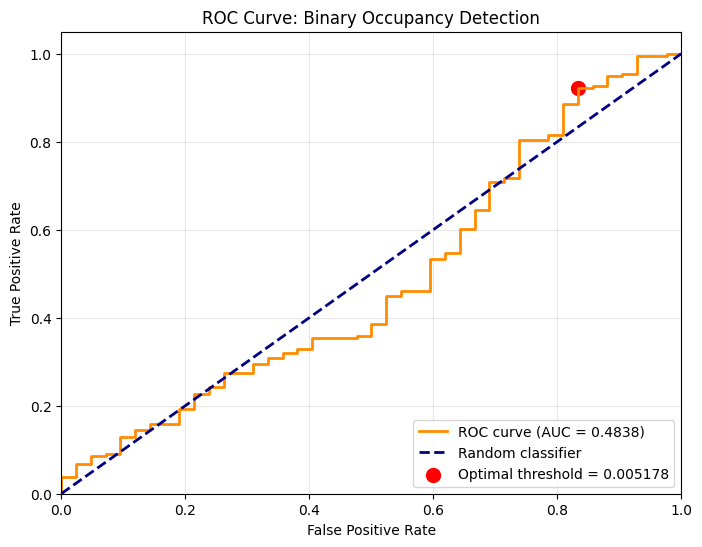

In [37]:
# Find optimal threshold using ROC curve
from sklearn.metrics import roc_curve, auc

# For threshold: lower error = NA (0), higher error = Occupied (1)
# So we need to invert: predict Occupied if error > threshold
fpr, tpr, thresholds = roc_curve(y_test_binary, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Find optimal threshold (maximize Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Optimal threshold: {optimal_threshold:.6f}")
print(f"At optimal threshold: TPR={tpr[optimal_idx]:.4f}, FPR={fpr[optimal_idx]:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, label=f'Optimal threshold = {optimal_threshold:.6f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Binary Occupancy Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## 10. Stage 2: Visualize Training

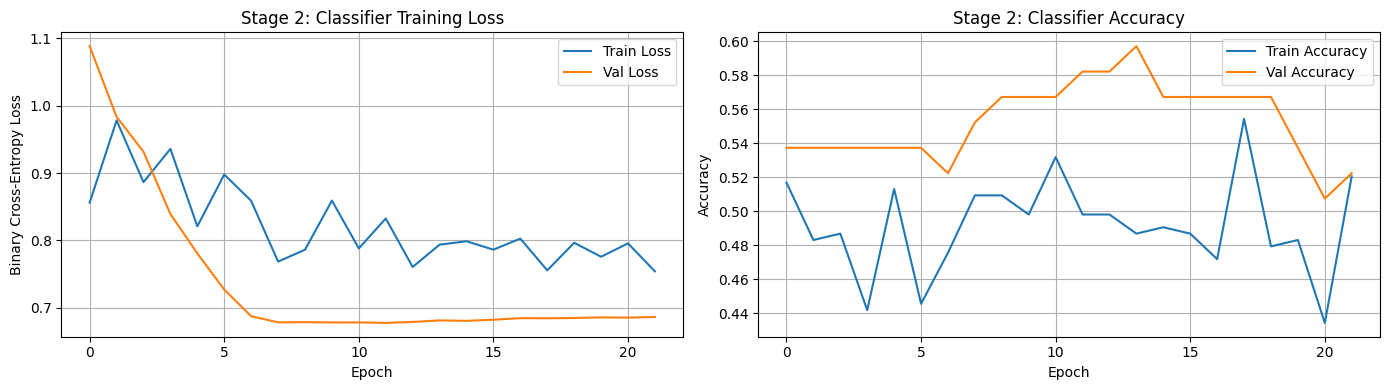

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history_cls.history['loss'], label='Train Loss')
axes[0].plot(history_cls.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary Cross-Entropy Loss')
axes[0].set_title('Stage 2: Classifier Training Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history_cls.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_cls.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 2: Classifier Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 11. Evaluation on Test Set

Test on full dataset: NA validation + all non-NA activities.


BINARY OCCUPANCY DETECTION RESULTS (Option A)
Accuracy:  0.8043
Precision: 0.8600
Recall:    0.9188
F1 Score:  0.8884

Confusion Matrix:
                Predicted
                NA    Occupied
Actual NA       7      35    
Actual Occupied 19     215   

NA detection accuracy:       16.67%
Occupied detection accuracy: 91.88%


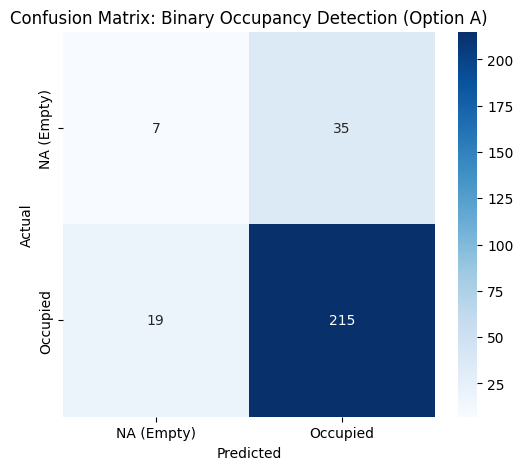

In [39]:
# Evaluate with optimal threshold
y_pred = (reconstruction_errors > optimal_threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print("\n" + "="*50)
print("BINARY OCCUPANCY DETECTION RESULTS (Option A)")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("="*50)

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred)
print("\nConfusion Matrix:")
print("                Predicted")
print("                NA    Occupied")
print(f"Actual NA       {cm[0,0]:<6} {cm[0,1]:<6}")
print(f"Actual Occupied {cm[1,0]:<6} {cm[1,1]:<6}")

# Calculate per-class accuracy
na_accuracy = cm[0,0] / (cm[0,0] + cm[0,1])
occupied_accuracy = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"\nNA detection accuracy:       {na_accuracy:.2%}")
print(f"Occupied detection accuracy: {occupied_accuracy:.2%}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NA (Empty)', 'Occupied'],
            yticklabels=['NA (Empty)', 'Occupied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Binary Occupancy Detection (Option A)')
plt.show()

## 12. Reconstruction Error Analysis

Compare reconstruction errors between NA and non-NA samples.

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Reconstruction Error Statistics:
NA (Empty):       Mean=0.008632, Std=0.002572
Occupied:         Mean=0.009295, Std=0.003422
Difference:       0.000663


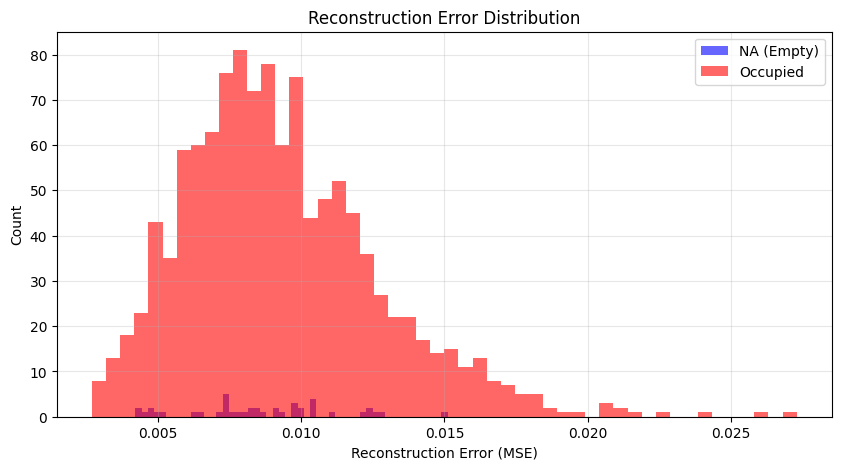

In [40]:
# Compute reconstruction errors
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)

# Split by actual class
errors_na = reconstruction_errors[y_test == 0]
errors_occupied = reconstruction_errors[y_test == 1]

print(f"\nReconstruction Error Statistics:")
print(f"NA (Empty):       Mean={errors_na.mean():.6f}, Std={errors_na.std():.6f}")
print(f"Occupied:         Mean={errors_occupied.mean():.6f}, Std={errors_occupied.std():.6f}")
print(f"Difference:       {errors_occupied.mean() - errors_na.mean():.6f}")

# Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(errors_na, bins=50, alpha=0.6, label='NA (Empty)', color='blue')
plt.hist(errors_occupied, bins=50, alpha=0.6, label='Occupied', color='red')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 13. Prediction Examples

In [41]:
# Show 10 random predictions
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), size=10, replace=False)

print("\nSample Predictions:")
print("-" * 70)
print(f"{'Index':<8} {'Actual':<12} {'Predicted':<12} {'Probability':<12} {'Correct'}")
print("-" * 70)

for idx in sample_indices:
    actual = 'NA' if y_test[idx] == 0 else 'Occupied'
    predicted = 'NA' if y_pred[idx] == 0 else 'Occupied'
    proba = y_pred_proba[idx][0]
    correct = '✓' if actual == predicted else '✗'
    
    print(f"{idx:<8} {actual:<12} {predicted:<12} {proba:<12.4f} {correct}")

print("-" * 70)


Sample Predictions:
----------------------------------------------------------------------
Index    Actual       Predicted    Probability  Correct
----------------------------------------------------------------------
101      Occupied     NA           0.4782       ✗


IndexError: index 787 is out of bounds for axis 0 with size 276